# Stock Price Predictions

We can also make testable predictions by restricting our model to a subset of the data, and then using the forecasted values to see how correct our model is. We will restrict data up until the end of 2016, and then try to make predictions for 2017.

In [91]:
import quandl 
import pandas as pd
import numpy as np
import fbprophet

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 22
matplotlib.rcParams['text.color'] = 'k'

In [67]:
matplotlib.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.form

## Retrieve Data from Quandl

In [2]:
quandl.ApiConfig.api_key = 'rFsSehe51RLzREtYhLfo'

# Using Tesla data
tesla_stocks = quandl.get('WIKI/TSLA')

In [3]:
# Set the index (with dates) to a column 
tesla_stocks.reset_index(level=0, inplace=True)

# Rename the columns for prophet and create a year column
tesla_stocks.rename(columns={'Date': 'ds', 'Adj. Close': 'y'}, inplace=True)
tesla_stocks['Year'] = [date.year for date in tesla_stocks['ds']]

In [4]:
tesla_stocks.head()

,ds,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,y,Adj. Volume,Year
0,2010-06-29,19.00,25.0000,17.54,23.89,18766300.0,0.0,1.0,19.00,25.0000,17.54,23.89,18766300.0,2010
1,2010-06-30,25.79,30.4192,23.30,23.83,17187100.0,0.0,1.0,25.79,30.4192,23.30,23.83,17187100.0,2010
2,2010-07-01,25.00,25.9200,20.27,21.96,8218800.0,0.0,1.0,25.00,25.9200,20.27,21.96,8218800.0,2010
3,2010-07-02,23.00,23.1000,18.71,19.20,5139800.0,0.0,1.0,23.00,23.1000,18.71,19.20,5139800.0,2010
4,2010-07-06,20.00,20.0000,15.83,16.11,6866900.0,0.0,1.0,20.00,20.0000,15.83,16.11,6866900.0,2010


In [5]:
# Create a new dataframe with the relevant information
tesla_data = tesla_stocks[['ds', 'Year', 'y']]

# Training and testing data
tesla_train = tesla_data[tesla_data['Year'] < 2017]
tesla_test = tesla_data[tesla_data['Year'] > 2016]

## Prophet Model

In [6]:
# Create a new model 
tesla_prophet = fbprophet.Prophet(changepoint_prior_scale=0.2)

# Train the model
tesla_prophet.fit(tesla_train)

# Number of days to make predictions 
days = (max(tesla_test['ds']) - min(tesla_test['ds'])).days

# Future dataframe
tesla_forecast = tesla_prophet.make_future_dataframe(periods = days, freq = 'D')

# Make forecasts
tesla_forecast = tesla_prophet.predict(tesla_forecast)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Accuracy and Profits (or losses)

In [198]:
tesla_results = tesla_forecast.merge(tesla_test, how = 'inner', on = 'ds')
tesla_results = tesla_results[['ds', 'y', 'yhat']]

# Predicted difference between stock prices
tesla_results['pred_diff'] = (tesla_results['yhat']).diff()

# Actual difference between stock prices
tesla_results['real_diff'] = (tesla_results['y']).diff()

In [199]:
# Correct direction column
tesla_results['correct'] = (np.sign(tesla_results['pred_diff']) == np.sign(tesla_results['real_diff'])) * 1
print('Correct direction predicted: {:0.2f}% of days.'.format(100 * np.mean(tesla_results['correct'])))

Correct direction predicted: 48.24% of days.


### Value of Predictions

In [200]:
# Need to include the adjusted open to calculate profits or losses
tesla_results = tesla_results.merge(tesla_stocks[['ds', 'Adj. Open']], how = 'left', on = 'ds')
tesla_results['daily_change'] = abs(tesla_results['y'] - tesla_results['Adj. Open'])

In [201]:
tesla_pred_increase = tesla_results[tesla_results['pred_diff'] > 0]
tesla_pred_increase.reset_index(inplace=True)

profits = []

for i, correct in enumerate(tesla_pred_increase['correct']):
    if correct == 1:
        profits.append(1000 * tesla_pred_increase.ix[i, 'daily_change'])
    else:
        profits.append(-1 * 1000 * tesla_pred_increase.ix[i, 'daily_change'])
        
tesla_pred_increase['profit'] = profits

In [202]:
print('Predicted profits: {:.0f} $.'.format(np.sum(tesla_pred_increase['profit'])))

Predicted profits: 24009 $.


In [204]:
smart_profit = 1000 * (tesla_results.ix[len(tesla_results) - 1, 'y'] - tesla_results.ix[0, 'Adj. Open'])
print('Buy and Hold profits: {:.0f} $.'.format(smart_profit))

Buy and Hold profits: 121550 $.


# Visualizations

In [205]:
tesla_plot = pd.merge(tesla_stocks, tesla_forecast, on = 'ds', how = 'inner')

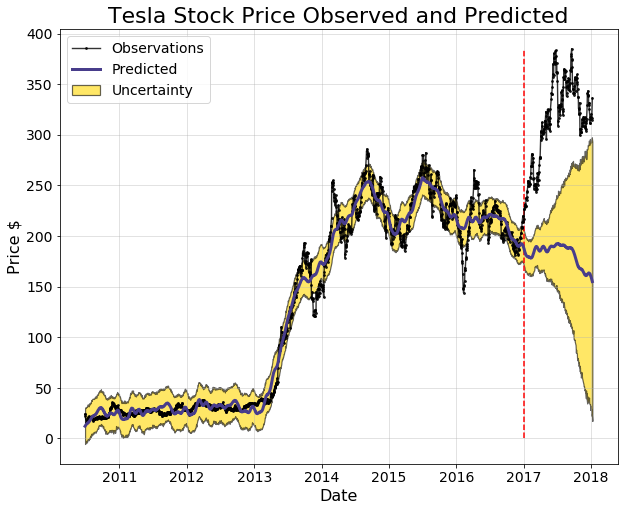

In [206]:
# Set up the plot
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the actual values
ax.plot(tesla_plot['ds'], tesla_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observations')
ax.plot(tesla_plot['ds'], tesla_plot['yhat'], 'darkslateblue',linewidth = 3, label = 'Predicted');

# Plot the uncertainty interval
ax.fill_between(tesla_plot['ds'].dt.to_pydatetime(), tesla_plot['yhat_upper'], tesla_plot['yhat_lower'], alpha = 0.6, 
               facecolor = 'gold', edgecolor = 'k', linewidth = 1.2, label = 'Uncertainty')

# Put a vertical line at the start of predictions
plt.vlines(x='2017-01-01', ymin=0, ymax=max(tesla_plot['y']), colors = 'r',
           linestyles='dashed')
plt.legend(loc = 2, prop={'size': 14}); plt.xlabel('Date'); plt.ylabel('Price $');
plt.grid(linewidth=0.6, alpha = 0.6)
plt.title('Tesla Stock Price Observed and Predicted');

In [207]:
# Merge results with the predicted increase containing profits
tesla_results = pd.merge(tesla_results, tesla_pred_increase[['ds', 'profit']], on = 'ds', how='left')

In [208]:
# Total predicted profit at each day
tesla_results['total_profit'] = tesla_results['profit'].cumsum()

In [212]:
# Forward fill the total profits
tesla_results.ix[0, 'total_profit'] = 0
tesla_results['total_profit'] = tesla_results['total_profit'].ffill()

In [214]:
# Calculate the profits from buying and holding
smart_profits = []
first_open = tesla_results.ix[0, 'Adj. Open']

for i, close in enumerate(tesla_results['y']):
    smart_profits.append(1000 * (close - first_open))
   
# No need for cumulative sum because smart profits are unrealized
tesla_results['total_smart'] = smart_profits

In [215]:
tesla_results.head()

,ds,y,yhat,pred_diff,real_diff,correct,Adj. Open,daily_change,profit,total_profit,total_smart
0,2017-01-03,216.99,187.136068,NaN,NaN,0,214.86,2.13,NaN,0.0,2130.0
1,2017-01-04,226.99,186.382225,-0.753843,10.00,0,214.75,12.24,NaN,0.0,12130.0
2,2017-01-05,226.75,185.686356,-0.695869,-0.24,1,226.42,0.33,NaN,0.0,11890.0
3,2017-01-06,229.01,184.887330,-0.799026,2.26,0,226.93,2.08,NaN,0.0,14150.0
4,2017-01-09,231.28,183.013857,-1.873472,2.27,0,228.97,2.31,NaN,0.0,16420.0


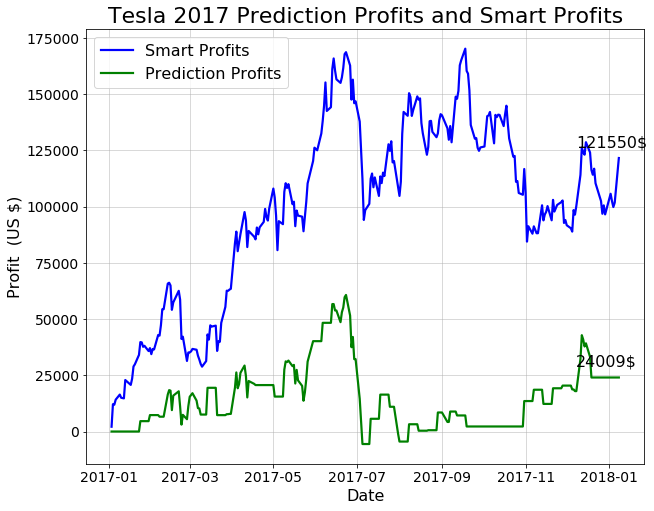

In [320]:
final_profit = tesla_results.ix[len(tesla_results) - 1, 'total_profit']
final_smart = tesla_results.ix[len(tesla_results) - 1, 'total_smart']
last_date = tesla_results.ix[len(tesla_results) - 1, 'ds']
text_location = (last_date - pd.DateOffset(months = 1)).date()

plt.figure(figsize=(10, 8))
plt.plot(tesla_results['ds'], tesla_results['total_smart'], 'b',
         linewidth = 2.2, label = 'Smart Profits') 
plt.plot(tesla_results['ds'], tesla_results['total_profit'], 
         color = 'g' if final_profit > 0 else 'r',
         linewidth = 2.2, label = 'Prediction Profits')
plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
plt.title('Tesla 2017 Prediction Profits and Smart Profits');
plt.legend(loc = 2, prop={'size': 16});
plt.grid(alpha=0.6); 
plt.text(x = text_location, 
         y =  final_profit + 5000,
         s = '%d$' % final_profit,
        color = 'k' if final_profit > 0 else 'r',
        size = 16)
plt.text(x = text_location, 
         y =  final_smart + 5000,
         s = '%d$' % final_smart,
        color = 'k' if final_smart > 0 else 'r',
        size = 16);

### Plotting Lines Segments with Different Colors (Not Used)

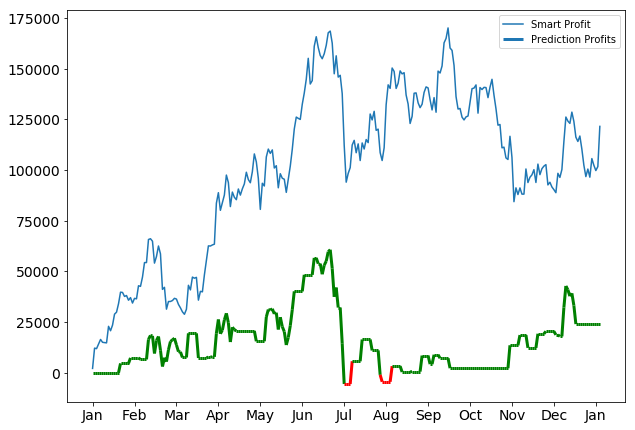

In [250]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


x = np.array(list(range(len(tesla_results))))
xlabels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
           'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan']

y = np.array(tesla_results['total_profit'])

# Create a colormap for red, green and blue and a norm to color
# f' < -0.5 red, f' > 0.5 blue, and the rest green
cmap = ListedColormap(['r', 'g'])
norm = BoundaryNorm([0], cmap.N)

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be numlines x points per line x 2 (x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection object, setting the colormapping parameters.
# Have to set the actual values used for colormapping separately.
lc = LineCollection(segments, label = 'Prediction Profits', cmap=cmap, norm=norm)
lc.set_array(y)
lc.set_linewidth(3)

xticks = list(range(0, x.max(), int(x.max() / 12)))

fig1 = plt.figure(figsize=(10,8))
fig1.autofmt_xdate()
plt.gca().add_collection(lc)
plt.plot(x, tesla_results['total_smart'], label = 'Smart Profit')
plt.xticks(xticks, xlabels);
plt.legend();

In [112]:
def plot_predictions(stock_df, forecast_df, ticker='TSLA'):
    # merge the two dataframes
    stock_plot = pd.merge(stock_df, forecast_df, on = 'ds', how = 'inner')
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot the actual values
    ax.plot(stock_plot['ds'], stock_plot['y'], 'ko-', linewidth = 1.4, alpha = 0.8, ms = 1.8, label = 'Observed')
    ax.plot(stock_plot['ds'], stock_plot['yhat'], 'darkslateblue',linewidth = 3, label = 'Predicted');

    # Plot the uncertainty interval
    ax.fill_between(stock_plot['ds'].dt.to_pydatetime(), stock_plot['yhat_upper'], stock_plot['yhat_lower'], alpha = 0.6, 
                   facecolor = 'gold', edgecolor = 'k', linewidth = 1.2, label = 'Uncertainty')

    # Put a vertical line at the start of predictions
    plt.vlines(x='2017-01-01', ymin=0, ymax=max(stock_plot['y']), colors = 'r',
               linestyles='dashed')
    plt.legend(loc = 2, prop={'size': 14}); plt.xlabel('Date'); plt.ylabel('Price $');
    plt.grid(linewidth=0.6, alpha = 0.6)
    plt.title('%s Price Observed and Predicted' % ticker);

In [328]:
def plot_profits(results, ticker):
    # Total predicted profit at each day
    results['total_profit'] = results['profit'].cumsum()
    
    # Forward fill the total predicted profits
    results.ix[0, 'total_profit'] = 0
    results['total_profit'] = results['total_profit'].ffill()
    
    # Calculate the profits from buying and holding
    smart_profits = []
    first_open = results.ix[0, 'Adj. Open']

    for i, close in enumerate(results['y']):
        smart_profits.append(1000 * (close - first_open))
    
    # Column with daily profits
    # No need for cumulative total because smart profits are unrealized
    results['total_smart'] = smart_profits
    
    # Final total profit and smart profit for plotting
    final_profit = results.ix[len(results) - 1, 'total_profit']
    final_smart = results.ix[len(results) - 1, 'total_smart']
    
    # Last date for location of text annotation
    last_date = results.ix[len(results) - 1, 'ds']
    text_location = (last_date - pd.DateOffset(months = 1)).date()

    # Set up the plot
    plt.figure(figsize=(10, 8))
    
    # Smart Profits
    plt.plot(results['ds'], results['total_smart'], 'b',
         linewidth = 2.2, label = 'Smart Profits') 
    
    # Prediction Profits
    plt.plot(results['ds'], results['total_profit'], 
         color = 'g' if final_profit > 0 else 'r',
         linewidth = 2.2, label = 'Prediction Profits')
    
    # Labels and Title
    plt.ylabel('Profit  (US $)'); plt.xlabel('Date'); 
    plt.title('%s 2017 Prediction Profits and Smart Profits' % ticker);
    
    # Legend and grid
    plt.legend(loc = 2, prop={'size': 16});
    plt.grid(alpha=0.6); 
    
    # Add label for final total profit
    plt.text(x = text_location, 
         y =  final_profit + 3000,
         s = '%d $' % final_profit,
        color = 'k' if final_profit > 0 else 'r',
        size = 16)
    # Add label for final smart profits
    plt.text(x = text_location, 
         y =  final_smart + 3000,
         s = '%d $' % final_smart,
        color = 'k' if final_smart > 0 else 'r',
        size = 16);

In [325]:
def stock_predictor(ticker='TSLA'):
    try:
        # Using years from 2011 onwards
        stock = quandl.get('WIKI/%s' % ticker.upper(), start_date = '2011-01-01')
    except Exception as e:
        print('Invalid Stock Ticker')
        print(e)
        return
    
    # Change the index to a Date column
    stock_clean = stock.reset_index()[['Date', 'Adj. Close', 'Adj. Open']]
    
    # Create a year column
    stock_clean['Year'] = [date.year for date in stock_clean['Date']]
    
    # Rename for prophet training
    stock_clean = stock_clean.rename(columns={'Date': 'ds', 'Adj. Close': 'y'})
    
    # Training and Testing Sets
    stock_train = stock_clean[stock_clean['Year'] < 2017]
    stock_test = stock_clean[stock_clean['Year'] > 2016]
    
    # Create the prophet model and fit on training set
    stock_prophet = fbprophet.Prophet(daily_seasonality=False,
                                      changepoint_prior_scale=0.2)
    stock_prophet.fit(stock_train)
    
    # Number of days to predict
    days = (max(stock_test['ds']) - min(stock_test['ds'])).days
    
    # Make forecasts for entire length of test set + one week
    stock_forecast = stock_prophet.make_future_dataframe(periods=days + 7, freq = 'D')
    stock_forecast = stock_prophet.predict(stock_forecast)
    
    # Plot the entire series
    plot_predictions(stock_clean, stock_forecast, ticker)
    
    # Dataframe for predictions and test values
    results = stock_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
    
    # Merge to get acutal values (y)
    results = pd.merge(results, stock_test[['ds', 'y']], on = 'ds', how='right')
    
    # Merge to get daily opening values (Adj. Open)
    results = results.merge(stock_clean[['ds', 'Adj. Open']], on = 'ds', how ='inner')
    
    # Columns of daily changes
    results['pred_diff'] = results['yhat'].diff()
    results['real_diff'] = results['y'].diff()
    
    # Whether the prediction was right or wrong
    # Multiply by 1 to convert to an integer
    results['correct'] = (np.sign(results['pred_diff']) == np.sign(results['real_diff'])) * 1
    
    # Calculate daily change in price
    results['daily_change'] = abs(results['y'] - results['Adj. Open'])
    
    # Only buy if predicted to increase
    results_pred_increase = results[results['pred_diff'] > 0]
        
    # Calculate profits or losses
    profits = []
    for i, correct in enumerate(results_pred_increase['correct']):
        if correct == 1:
            profits.append(1000 * results.ix[i, 'daily_change'])
        else:
            profits.append(-1 * 1000 * results.ix[i, 'daily_change'])
    
    results_pred_increase['profit'] = profits
    
    # Dataframe for plotting profits
    results = pd.merge(results, results_pred_increase[['ds', 'profit']], on = 'ds', how = 'left')
    
    # Plot the profits (or losses)
    plot_profits(results, ticker)
    
    # Calculate total profit if buying 1000 shares every day
    total_profit = int(np.sum(profits))
    
    # Calculate total profit if buying and holding 1000 shares for entire time
    first_price = int(results[results['ds'] == min(results['ds'])]['y'])
    last_price = int(results[results['ds'] == max(results['ds'])]['y'])

    # Smart profit
    smart_profit = (last_price - first_price) * 1000
    
    # Total accuracy is percentage of correct predictions
    accuracy = np.mean(results['correct']) *  100
    
    performance = {'pred_profit': total_profit, 'smart_profit': smart_profit, 'accuracy': accuracy}
    
    print('Your profit from playing the stock market in {}: {:.0f} $.'.format(ticker, total_profit))
    print('The buy and hold profit (smart strategy) for {}: {:.0f} $.'.format(ticker, smart_profit))
    print('Thanks for playing the stock market!')

Your profit from playing the stock market in TSLA: 25896 $.
The buy and hold profit (smart strategy) for TSLA: 120000 $.
Thanks for playing the stock market!


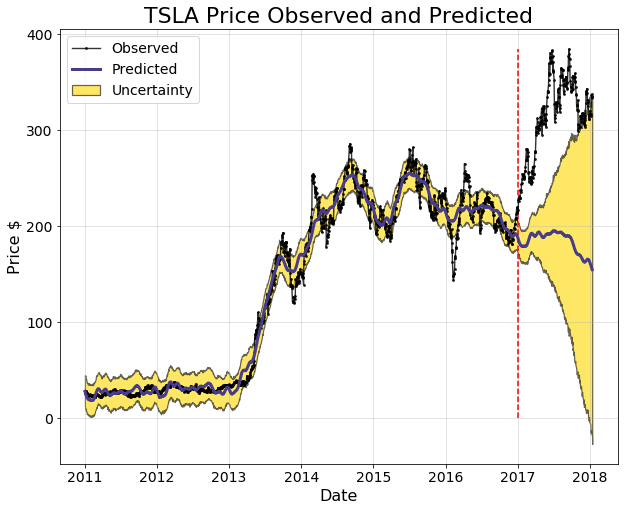

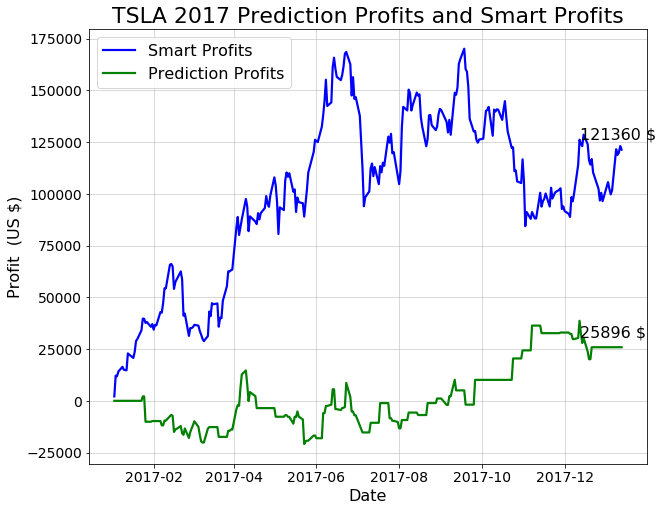

In [326]:
stock_predictor('TSLA')

Your profit from playing the stock market in CAT: 7692 $.
The buy and hold profit (smart strategy) for CAT: 79000 $.
Thanks for playing the stock market!


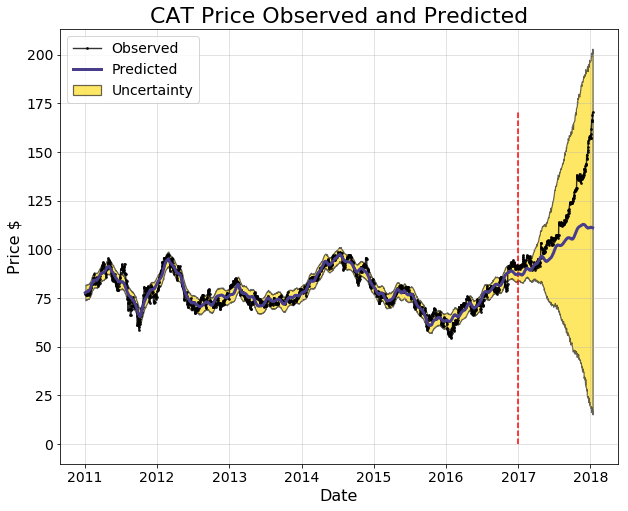

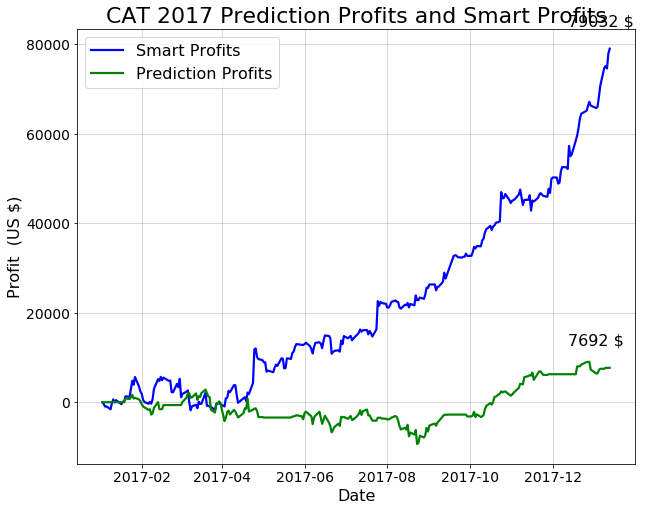

In [327]:
stock_predictor('CAT')